In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imageio import imread
import glob
from IPython.display import clear_output
import os  # 匯入os模組
import sys # 匯入sys模組
import pyodm # 匯入pyodm模組
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score


In [2]:
labels = []
features0=[]
with open('train.txt', 'r') as file:
    for line in file:
        image_file_name, label = line.strip().split(' ')
        image = Image.open(image_file_name)
        image_data_0 = np.array(image)
        
        labels_0=labels.append(label)
        
        image_data_0=cv2.cvtColor(image_data_0, cv2.COLOR_RGB2BGR)
        resized_image= cv2.resize(image_data_0, (32, 32))
        features0.append(resized_image)
features0 = np.array(features0)
labels_0=np.array(labels)
print(features0.shape)
features0 = features0.astype("float32") / 255.0

# 轉換為灰階圖片
gray_data_0 = np.mean(features0, axis=3, keepdims=True)
print(gray_data_0.shape)

labels = []
features1=[]
with open('test.txt', 'r') as file:
    for line in file:
        image_file_name, label = line.strip().split(' ')
        image = Image.open(image_file_name)
        image_data_1 = np.array(image)
        
        labels_1=labels.append(label)
        
        image_data_1=cv2.cvtColor(image_data_1, cv2.COLOR_RGB2BGR)
        resized_image= cv2.resize(image_data_1, (32, 32))
        features1.append(resized_image)
features1 = np.array(features1)
labels_1=np.array(labels)
print(features1.shape)
features1 = features1.astype("float32") / 255.0

# 轉換為灰階圖片
gray_data_1 = np.mean(features1, axis=3, keepdims=True)
print(gray_data_1.shape)

labels = []
features2=[]
with open('val.txt', 'r') as file:
    for line in file:
        image_file_name, label = line.strip().split(' ')
        image = Image.open(image_file_name)
        image_data_2 = np.array(image)
        
        labels_2=labels.append(label)
        
        image_data_2=cv2.cvtColor(image_data_2, cv2.COLOR_RGB2BGR)
        resized_image= cv2.resize(image_data_2, (32, 32))
        features2.append(resized_image)
features2 = np.array(features2)
labels_2=np.array(labels)
print(features2.shape)
features2 = features2.astype("float32") / 255.0

# 轉換為灰階圖片
gray_data_2 = np.mean(features2, axis=3, keepdims=True)
print(gray_data_2.shape)


(63325, 32, 32, 3)
(63325, 32, 32, 1)
(450, 32, 32, 3)
(450, 32, 32, 1)
(450, 32, 32, 3)
(450, 32, 32, 1)


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from thop import profile
start_time = time.time()
from keras_flops import get_flops
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 將 x_train 和 y_train 轉換為 Tensor
(x_train, y_train), (x_val, y_val) = (gray_data_0,labels_0),(gray_data_2,labels_2)
y_train = y_train.astype(np.float32) 
y_val=y_val.astype(np.float32)
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_val = torch.Tensor(x_val)
x_val = torch.Tensor(x_val.reshape(x_val.shape[0], 32, 32, 1))
x_test, y_test=gray_data_1,labels_1
y_test=y_test.astype(np.float32)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)
y_val = torch.tensor(y_val)
# 將 x_test 轉換為 (資料筆數, 32, 32, 1) 的形狀
x_test = torch.Tensor(x_test.reshape(x_test.shape[0], 32, 32, 1))

x_test = x_test.permute(0, 3, 1, 2)

# 將資料 reshape 成 (samples, channels, height, width) 的形狀
x_train = x_train.permute(0, 3, 1, 2)  # 將最後一個維度移至第二個維度
x_val= x_val.permute(0, 3, 1, 2)

model= LeNet5()
# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



# 訓練模型
num_epochs = 10
batch_size = 32
val_accuracy_list=[]
train_accuracy_list=[]
for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        batch_x = x_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        # 正向傳遞
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # 反向傳遞和優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 打印訓練過程中的損失
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(x_train), loss.item()))
    with torch.no_grad():
        val_predicted = model(x_val)
        val_predicted_labels = torch.round(val_predicted).squeeze()
        val_accuracy = torch.mean((val_predicted_labels == y_val.float().to(val_predicted_labels.device)).type(torch.FloatTensor)).item()

        val_accuracy_list.append(val_accuracy)
    # 計算訓練準確度
    with torch.no_grad():
        model.eval()  # 將模型設定為評估模式
        train_predicted = model(x_train)
        train_predicted_labels = torch.round(train_predicted).squeeze()
        train_accuracy = (train_predicted_labels == y_train).sum().item() / len(y_train)
        train_accuracy_list.append(train_accuracy)

    # 打印訓練準確度
    print('Training Accuracy: {:.2f}%'.format(train_accuracy * 100))
    # 使用測試集進行預測並計算準確度
    with torch.no_grad():
        test_predicted = model(x_test)
        test_predicted_labels = torch.round(test_predicted).squeeze()
        test_accuracy = (test_predicted_labels == y_test).sum().item() / len(y_test)

    # 打印驗證準確度和測試準確度
    print('Validation Accuracy: {:.2f}%'.format(val_accuracy_list[-1] * 100))
    print('Test Accuracy: {:.2f}%'.format(test_accuracy * 100))

# 使用訓練好的模型進行預測
#predicted = model(x_train)
# 資料前處理


# 轉換為 (samples, channels, height, width) 的形狀


# 使用訓練好的模型進行預測
predicted = model(x_test)

# 將預測結果轉換為類別標籤
predicted_labels = torch.round(predicted).squeeze()

# 計算準確度
accuracy = (predicted_labels == y_test).sum().item() / len(y_test)
end_time = time.time()
print('Accuracy: {:.2f}%'.format(accuracy * 100))
execution_time = end_time - start_time
print("代码执行时间：", execution_time, "秒")
keras_model = torch.hub.load('mit-han-lab/ProxylessNAS', 'proxyless_cpu', pretrained=True)
keras_model = torch.nn.Sequential(keras_model, torch.nn.Flatten())

# Calculate the FLOPs using the get_flops function
input_shape = (1, 1, 32, 32)  # Example input shape, adjust according to your data
input_tensor = torch.randn(*input_shape)

# Calculate the FLOPs using the profile function from thop
flops, params = profile(model, inputs=(input_tensor,))
print("FLOPs: {:.2f} G".format(flops / 1e9))


Training Accuracy: 2.02%
Validation Accuracy: 2.00%
Test Accuracy: 2.00%
Training Accuracy: 2.02%
Validation Accuracy: 2.00%
Test Accuracy: 2.00%
Training Accuracy: 2.02%
Validation Accuracy: 2.00%
Test Accuracy: 2.00%
Training Accuracy: 2.02%
Validation Accuracy: 2.00%
Test Accuracy: 2.00%
Training Accuracy: 2.02%
Validation Accuracy: 2.00%
Test Accuracy: 2.00%
Training Accuracy: 2.02%
Validation Accuracy: 2.00%
Test Accuracy: 2.00%
Training Accuracy: 2.02%
Validation Accuracy: 2.00%
Test Accuracy: 2.00%
Training Accuracy: 2.02%
Validation Accuracy: 2.00%
Test Accuracy: 2.00%
Training Accuracy: 2.02%
Validation Accuracy: 2.00%
Test Accuracy: 2.00%
Training Accuracy: 2.02%
Validation Accuracy: 2.00%
Test Accuracy: 2.00%
Accuracy: 2.00%
代码执行时间： 88.4767644405365 秒
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>

Using cache found in C:\Users\User/.cache\torch\hub\mit-han-lab_ProxylessNAS_master


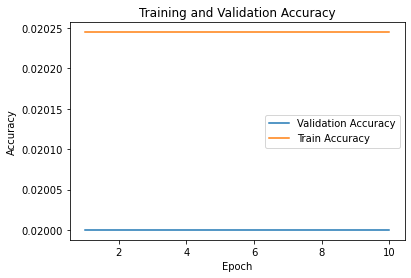

In [37]:
import matplotlib.pyplot as plt

# 繪製訓練準確度和驗證準確度曲線
plt.plot(range(1, num_epochs + 1), val_accuracy_list, label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1),train_accuracy_list, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
